In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

df = pd.read_excel(r"C:\Users\brend\OneDrive - Stonehill College\All Cape League Trackman.xlsx")

C:\Users\brend\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = df.dropna(subset=[
    "pfxx", "pfxz", "Extension", "PlateLocSide",
    "RelSpeed", "SpinRate", "TaggedPitchType", "PitcherTeam"
])

valid_pitches = ["Four-Seam", "Slider", "Sinker", "Two-Seam", "Cutter", "ChangeUp"]

df = df[df["TaggedPitchType"].isin(valid_pitches)]
df = df[df["PitcherTeam"] == "FAL_COM"]

features = [
    "pfxx", "pfxz", "Extension",
    "PlateLocSide", "RelSpeed", "SpinRate", "SpeedDrop"
]

df[features] = df[features].apply(pd.to_numeric, errors='coerce')

df = df.dropna(subset=features)

min_pitches = 15
pitch_counts = df.groupby(["Pitcher", "TaggedPitchType"]).size().unstack(fill_value=0)
qualified_pitchers = pitch_counts[(pitch_counts >= min_pitches).sum(axis=1) >= 2].index
df = df[df["Pitcher"].isin(qualified_pitchers)]

def compute_kde_deception(pitch_df, features, bandwidth=0.3):
    deception_scores = []
    for i, row in pitch_df.iterrows():
        current = row[features].to_numpy(dtype=float)
        pitch_type = row["TaggedPitchType"]
        pitcher = row["Pitcher"]
        ref_df = df[(df["Pitcher"] == pitcher) & (df["TaggedPitchType"] != pitch_type)]

        min_samples = len(features) * 5
        if len(ref_df) < min_samples:
            deception_scores.append(np.nan)
            continue

        kde = gaussian_kde(ref_df[features].values.T, bw_method=bandwidth)
        score = kde(current)
        deception_scores.append(score[0])
    return deception_scores

df["KDE_Deception_Score"] = compute_kde_deception(df, features)

pitcher_counts = df.groupby(["Pitcher", "TaggedPitchType"]).size().reset_index(name="Count")
pitcher_avg_scores = (
    df.groupby(["Pitcher", "TaggedPitchType"])["KDE_Deception_Score"]
    .mean()
    .reset_index()
    .merge(pitcher_counts, on=["Pitcher", "TaggedPitchType"])
)

pitcher_avg_scores = pitcher_avg_scores[pitcher_avg_scores["Count"] >= min_pitches]

pitcher_avg_scores = pitcher_avg_scores.sort_values("KDE_Deception_Score", ascending=True)

pitcher_avg_scores["KDE_Deception_Score"] = pitcher_avg_scores["KDE_Deception_Score"].replace(0, 1e-320)

pitcher_avg_scores["Log_Deception_Score"] = -np.log10(pitcher_avg_scores["KDE_Deception_Score"])
pitcher_avg_scores["Log_Deception_Score"] = pitcher_avg_scores["Log_Deception_Score"].round(2)

print(pitcher_avg_scores.head(10))

            Pitcher TaggedPitchType  KDE_Deception_Score  Count  \
47  O'Harran, Toran          Slider        9.999889e-321     22   
32  Humphrey, Kaden          Slider        9.999889e-321     24   
79    Stiffler, Mac          Slider        9.999889e-321     60   
75   Sheerin, Deven          Slider        9.999889e-321     52   
68    Schulz, Jakob        ChangeUp        9.881313e-324     25   
17        Coats, TJ          Slider        3.256489e-239    131   
61     Sabbath, Joe          Slider        4.236497e-185     87   
22  Dallas, Matthew          Slider        4.565528e-149     58   
59     Sabbath, Joe        ChangeUp        1.682009e-105     16   
5   Baumler, Trever       Four-Seam         1.132178e-97    165   

    Log_Deception_Score  
47               320.00  
32               320.00  
79               320.00  
75               320.00  
68               323.01  
17               238.49  
61               184.37  
22               148.34  
59               104.77  
5 

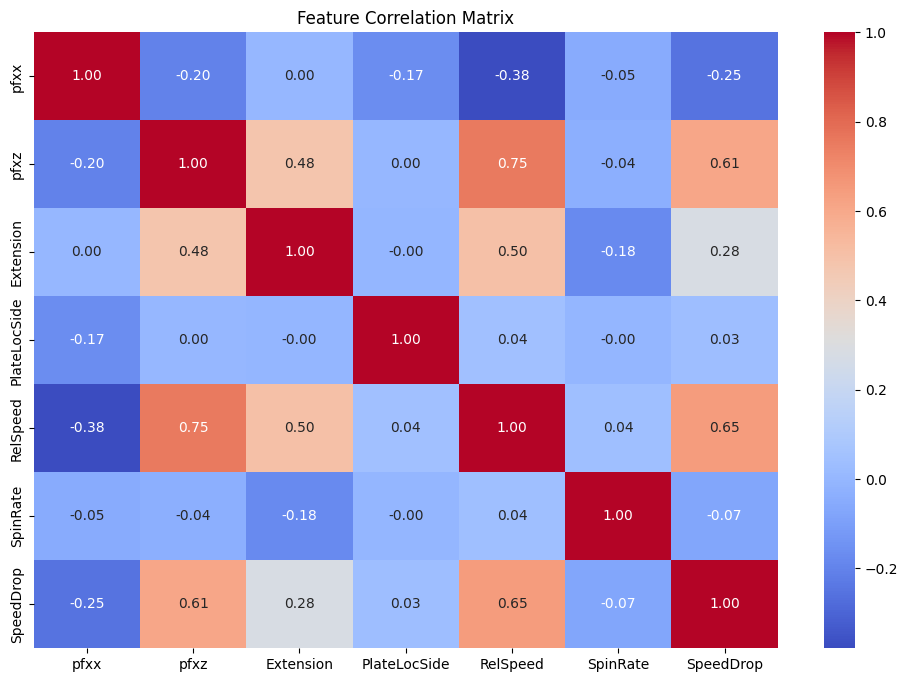

In [3]:
corr_matrix = df[features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()

C:\Users\brend\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:09:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


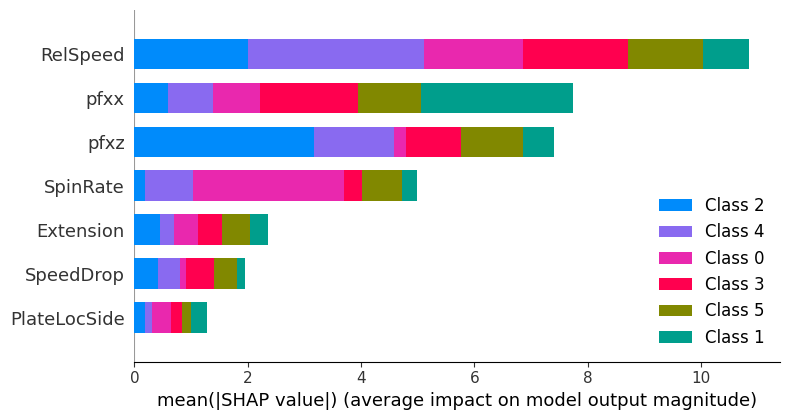

array(['Slider', 'ChangeUp', 'Sinker', 'Four-Seam'], dtype=object)

In [4]:
X = df[features]
y = df["TaggedPitchType"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features)
df[df["Pitcher"] == "Stiffler, Mac"]["TaggedPitchType"].unique()


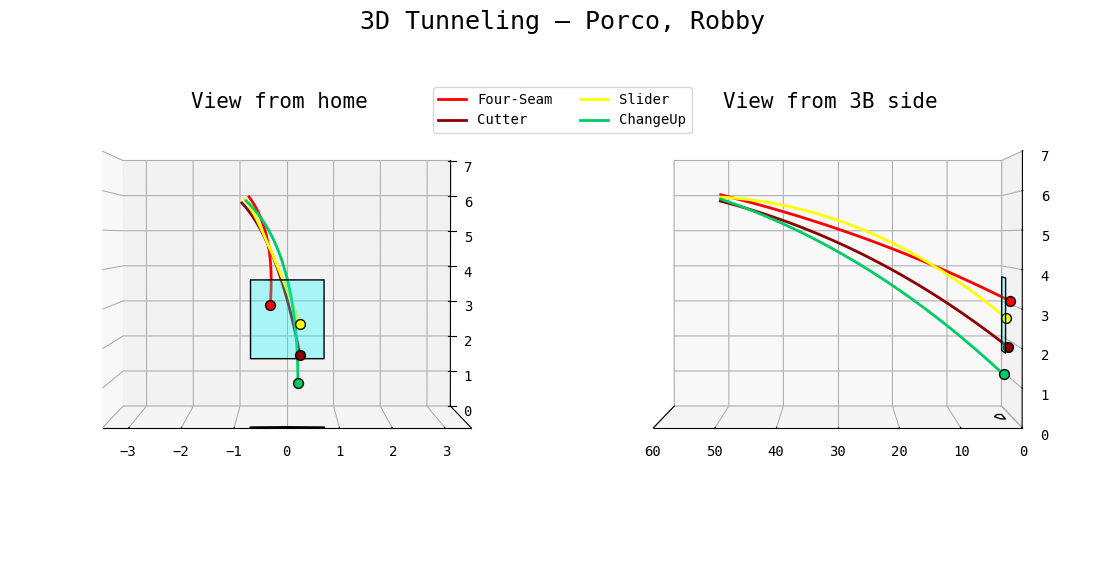

In [16]:
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

def get_avg_pitch(df, pitcher, pitch_type):
    subset = df[(df["Pitcher"] == pitcher) & (df["TaggedPitchType"] == pitch_type)]
    if subset.empty:
        return None
    metrics = ["x0", "y0", "z0", "vx0", "vy0", "vz0", "ax0", "ay0", "az0"]
    return subset[metrics].mean().to_dict()

def simulate_flight(pitch, dt=0.01):
    x, y, z = [pitch["x0"]], [pitch["y0"]], [pitch["z0"]]
    vx, vy, vz = pitch["vx0"], pitch["vy0"], pitch["vz0"]
    ax, ay, az = pitch["ax0"], pitch["ay0"], pitch["az0"]

    while y[-1] > 1.417:
        x_new = x[-1] + vx*dt + 0.5*ax*dt**2
        y_new = y[-1] + vy*dt + 0.5*ay*dt**2
        z_new = z[-1] + vz*dt + 0.5*az*dt**2

        vx += ax*dt
        vy += ay*dt
        vz += az*dt

        x.append(x_new)
        y.append(y_new)
        z.append(z_new)

    return np.array(x), np.array(y), np.array(z)

def add_strike_zone(ax):
    x_min, x_max = -0.7, 0.7
    z_min, z_max = 1.75, 3.75
    y_plate = 1.417
    verts = [[
        (x_min, y_plate, z_min),
        (x_max, y_plate, z_min),
        (x_max, y_plate, z_max),
        (x_min, y_plate, z_max)
    ]]
    poly = Poly3DCollection(verts, facecolors='cyan', edgecolors='k', alpha=0.3)
    ax.add_collection3d(poly)

def add_home_plate(ax, y_plate=1.417, plate_width=1.417, plate_depth=0.85, point_depth=0.71, z_offset=0.0):

    half_width = plate_width / 2

    verts = [[
        (-half_width, y_plate, z_offset),
        (half_width, y_plate, z_offset),
        (half_width, y_plate + plate_depth, z_offset),
        (0, y_plate + plate_depth + point_depth, z_offset),
        (-half_width, y_plate + plate_depth, z_offset)
    ]]

    poly = Poly3DCollection(verts, facecolors='white', edgecolors='k', alpha=1.0)
    ax.add_collection3d(poly)

def fix_xz_aspect(ax):
    x_min, x_max = ax.get_xlim3d()
    z_min, z_max = ax.get_zlim3d()
    max_range = max(x_max - x_min, z_max - z_min)
    x_mid = (x_max + x_min) / 2
    z_mid = (z_max + z_min) / 2
    ax.set_xlim3d(x_mid - max_range/2, x_mid + max_range/2)
    ax.set_zlim3d(z_mid - max_range/2, z_mid + max_range/2)

def plot_tunneling_3d_multi(df, pitcher, pitch_types=("Four-Seam", "Cutter", "Slider", "ChangeUp"),
                            color_scheme=None):
    if color_scheme is None:
        color_scheme = {
            "Four-Seam": "red",
            "Cutter": "orange",
            "Slider": "blue",
            "ChangeUp": "green"
        }
    
    fig = plt.figure(figsize=(16, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    for pitch_type in pitch_types:
        pitch = get_avg_pitch(df, pitcher, pitch_type)
        if pitch is None:
            continue

        x, y, z = simulate_flight(pitch)
        color = color_scheme.get(pitch_type, "black")

        for ax in [ax1, ax2]:
            ax.plot(x, y, z, color=color, label=pitch_type, linewidth=2)
            ax.scatter(x[-1], y[-1], z[-1], color=color, s=50, edgecolors='k')

    for ax in [ax1, ax2]:
        add_strike_zone(ax)
        add_home_plate(ax)
        ax.set_xlim(-2, 2)
        ax.set_ylim(0, 60)
        ax.set_zlim(0, 7)
        ax1.set_yticks([])

    ax1.view_init(elev=1, azim=270)
    ax1.set_title("View from home", y=0.9, fontsize=15)
    fix_xz_aspect(ax1)

    ax2.view_init(elev=1, azim=180)
    ax2.set_title("View from 3B side", y=0.9, fontsize=15)
    ax2.set_xticks([])
    fix_xz_aspect(ax2)

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.517, 0.8), ncol=2)

    fig.suptitle(f"3D Tunneling – {pitcher}", y=0.9, x=.517, fontsize=18)
    fig.subplots_adjust(wspace=-.2)
    plt.show()

custom_colors = {
    "Four-Seam": "#FF0000",
    "Two-Seam": "#FF6666",
    "Sinker": "#FFA500",
    "ChangeUp": "#00CC66",
    "Slider": "#FFFF00",
    "Curveball": "#ADD8E6",
    "Cutter": "#8B0000",
    "Splitter": "#008080"
}

plot_tunneling_3d_multi(df, pitcher="Porco, Robby", 
                        pitch_types=("Four-Seam", "Cutter", "Slider", "ChangeUp"),
                        color_scheme=custom_colors)